<b>AML2019</b>

<h3>Challenge 1</h3>
<h1>House Pricing Prediction</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>
<i>22<sup>th</sup> March 2019</i>

The first AML challenge for this year is adapted from the well-known '<i>Zillow's Home Value Prediction</i>' competition on Kaggle.
In particular, given a dataset containing descriptions of homes on the US property market, your task is to make predictions on the selling price of as-yet unlisted properties. 
Developing a model which accurately fits the available training data while also generalising to unseen data-points is a multi-faceted challenge that involves a mixture of data exploration, pre-processing, model selection, and performance evaluation.

# Overview
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

Beyond simply producing a well-performing model for making predictions, in this challenge we would like you to start developing your skills as a machine learning scientist.
In this regard, your notebook should be structured in such a way as to explore the five following tasks that are expected to be carried out whenever undertaking such a project.
The description below each aspect should serve as a guide for your work, but you are strongly encouraged to also explore alternative options and directions. 
Thinking outside the box will always be rewarded in these challenges.

In [2]:
%matplotlib inline
import os
import sys
import re
import random
import matplotlib
import sklearn
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time

base = "challenge_data/"

<div class="">
    <h3>1. Data Exploration</h3>
</div>

The first broad component of your notebook should enable you to familiarise yourselves with the given data, an outline of which is given at the end of this challenge specification.
Among others, this section should investigate:

- Data cleaning, e.g. treatment of categorial variables;
- Data visualisation;
- Computing descriptive statistics, e.g. correlation.
- etc.

In [3]:
##########################################
############# DATA IMPORT ################
##########################################

house_data = pd.read_csv(base + 'train.csv')

#extract the regressand column and remove it from the train data
prices = house_data.loc[:,"SalePrice"]
train_data = house_data.drop(["Id", "SalePrice"],1) #we also remove the useless ID

train_data[:10]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal


In [4]:
#from the data description file, extract the features that have listed categories
    #these are categorical features and have to be treated properly
#count how many categories are present for each feature

headers = list(train_data)
i = 1
cat_dict = {}
#first lines are not clean: better to insert this feature manually
cat_dict['MSSubClass'] = 0

with open(base + 'Data description.rtf') as f:
    lines = f.readlines()[10:-1]
    for line in lines:
        word = line.split()[0]
        if word[-1] == ":":
            
            #if the last features has no categories (which means it is numerical), remove it from the dictionary
            if cat_dict[headers[i - 1]] == 0:
                cat_dict.pop(headers[i - 1], 'None')
                
            cat_dict[headers[i]] = 0
            if i < len(headers):
                i += 1
        
        #if the line does not contain a feature name and it does not start with a backslash, it is a category
        #to be assigned to the last seen feature
        elif word != "\\":
            cat_dict[headers[i - 1]] += 1

#the following two features are listed as categorical, but they have indeed numerical values from 1 to 10
#they can be managed as numerical features, we remove them manually
cat_dict.pop('OverallQual', 'None')
cat_dict.pop('OverallCond', 'None')

#now that we have distinguished numerical and categorical values, we split the original dataset
#this way, we can consider the two cases separately
train_data_cat = train_data[[x for x in cat_dict.keys()]]
train_data_num = train_data[[x for x in list(train_data)if x not in cat_dict.keys()]]

print("%d categorical columns" %len(list(train_data_cat)))
print("%d numerical columns" %len(list(train_data_num)))

44 categorical columns
35 numerical columns


In [55]:
################################
######## DATA CLEANING  ########
################################

mask = ~train_data_num.isnull().any(axis = 1)
train_data_cat = train_data_cat[mask.values]


ValueError: Item wrong length 1200 instead of 0.

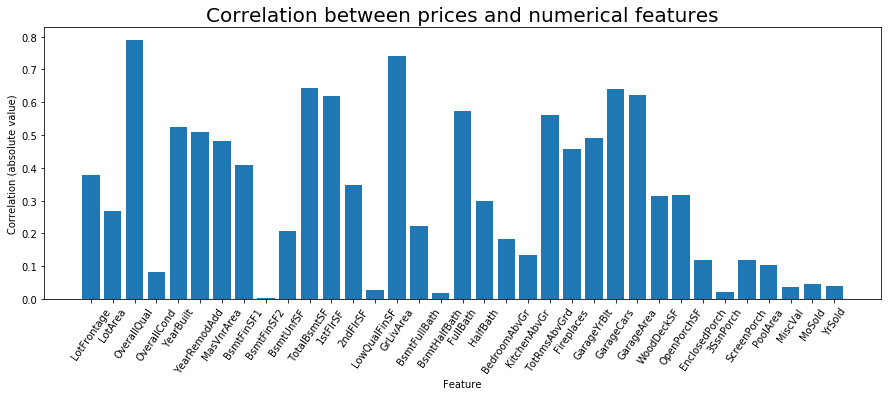

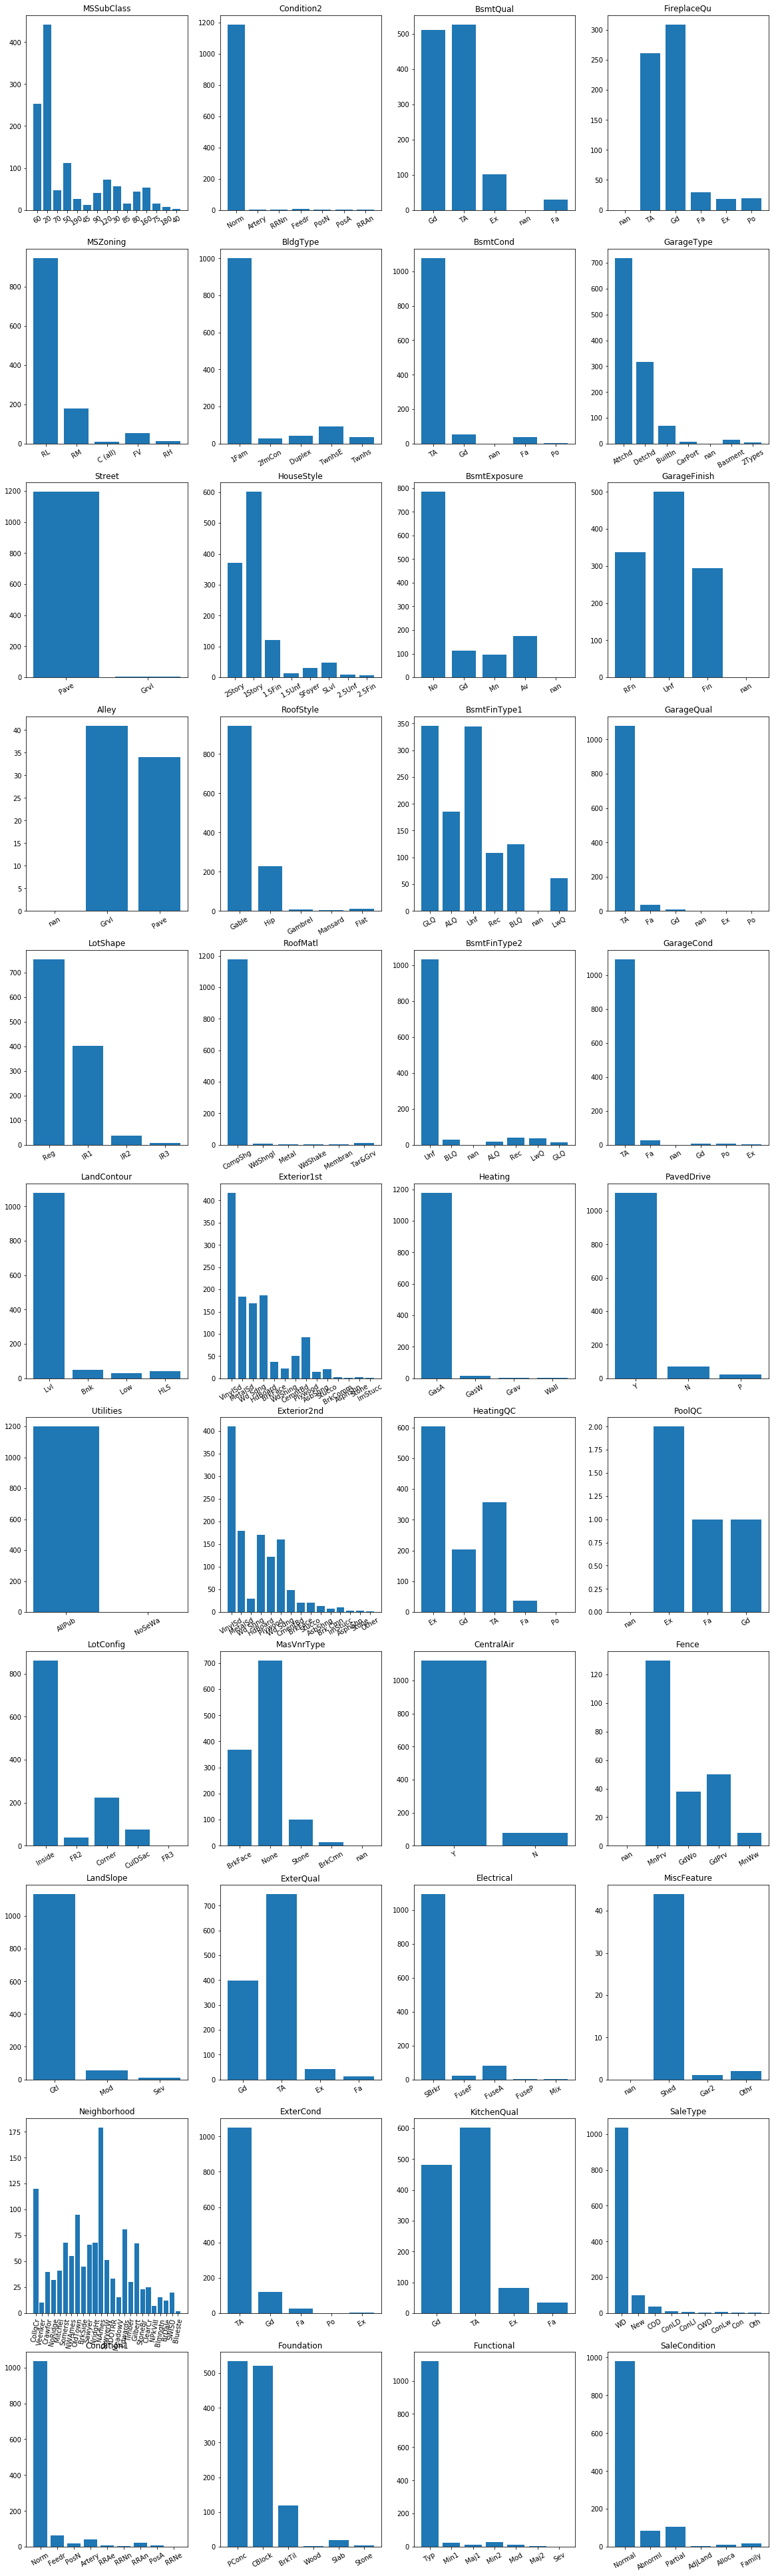

In [18]:
corr = pd.concat([train_data_num, prices], axis = 1).corr().loc[:,"SalePrice"].abs()
plt.figure(figsize = (15,5))
plt.title("Correlation between prices and numerical features", fontsize = 20)
plt.xlabel("Feature")
plt.ylabel("Correlation (absolute value)")
plt.bar(range(len(corr.index[:-1])), corr.values[:-1])
plt.xticks(range(len(corr.index[:-1])), corr.index[:-1], rotation = 55)
plt.show()

fig, ax = plt.subplots(11,4, figsize = (20,70))
a = 0
b = 0
for key in list(train_data_cat):
    ax[a,b].set_title(key)
    ncat = train_data_cat[key].unique().size
    ax[a,b].bar(range(ncat),
                [(train_data_cat[key] == value).sum() for value in train_data_cat[key].unique()],
                tick_label = train_data_cat[key].unique())
    ax[a,b].set_xticklabels(train_data_cat[key].unique(), rotation = 30)
    if len(train_data_cat[key].unique()) > 20:
        ax[a,b].set_xticklabels(train_data_cat[key].unique(), rotation = 80)
    a += 1
    if a == 11:
        b += 1
        a = 0
        

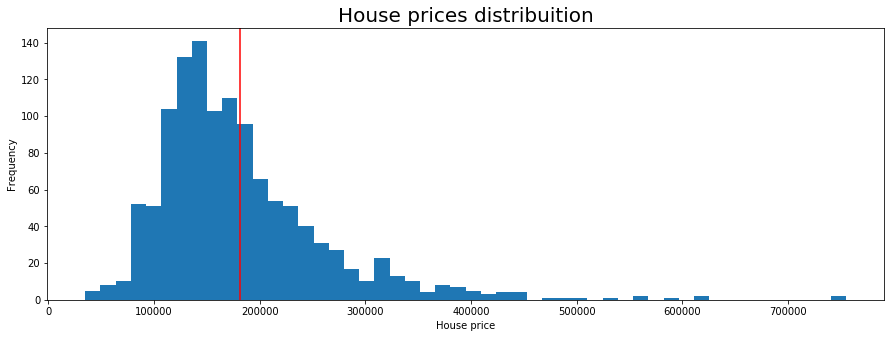

In [7]:
plt.figure(figsize = (15,5))
plt.hist(prices, bins = 50)
plt.title("House prices distribuition", fontsize = 20)
plt.xlabel("House price")
plt.ylabel("Frequency")
plt.axvline(prices.mean(), label='Average price = %.3f' % prices.mean(), color = 'r')
plt.show()

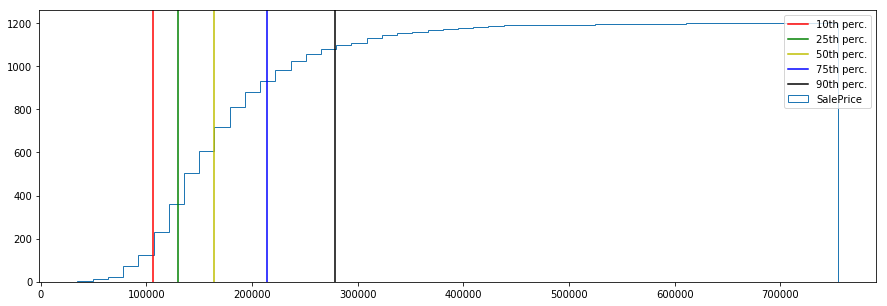

In [9]:
fig, ax = plt.subplots(figsize=(15,5))

# Plot the cumulative distribution
ax.hist(prices,bins=50, cumulative=True, histtype='step')

# Calculate and plot the 5 important percentiles
colors=['r','g','y','b','k']
for i, quantile in enumerate([.1, 0.25, .5, .75, .9]):
    ax.axvline(prices.quantile(quantile), label='%.0fth perc.' % (quantile*100),color=colors[i])
    
ax.legend()
plt.show()

<div class="">
    <h3>2. Data Pre-processing</h3>
</div>

The previous step should give you a better understanding of which pre-processing is required for the data.
This may include:

- Normalising and standardising the given data;
- Removing outliers;
- Carrying out feature selection, possibly using metrics derived from information theory;
- Handling missing information in the dataset;
- Augmenting the dataset with external information;
- Combining existing features.

In [10]:
#to perform regression with categorical values, it is necessary to dummy encode the categories
#if a feature has n categories (n as extracted by the training data), n binary features are created
#only one of these new features can be equal to 1 for each entry
enc = preprocessing.OneHotEncoder(categories = [list(house_data_cat[key].unique()) for key in list(house_data_cat)],
                                          handle_unknown = 'ignore')

enc.fit([house_data_cat.iloc[[i]].values[0] for i in range(len(house_data_cat))]);

dummy = enc.transform([house_data_cat.iloc[[i]].values[0] for i in range(len(house_data_cat))])

house_data_cat_dummy = pd.DataFrame(columns = enc.get_feature_names())
for i,key in enumerate(list(house_data_cat_dummy)):
    my_list = map(lambda x: x[0], dummy[:,i].toarray())
    house_data_cat_dummy[key] = pd.Series(my_list)

In [18]:
new_df = pd.concat([house_data_cat_dummy,house_data_num], axis = 1)
new_df = new_df.drop("SalePrice", axis = 1)
new_df.shape

(1200, 308)

<div class="">
    <h3>3. Model Selection</h3>
</div>

Perhaps the most important segment of this challenge involves the selection of a model that can successfully handle the given data and yield sensible predictions.
Instead of focusing exclusively on your final chosen model, it is also important to share your thought process in this notebook by additionally describing alternative candidate models.
There is a wealth of models to choose from, such as <i>decision trees</i>, <i>random forests</i>, <i>(Bayesian) neural networks</i>, <i>Gaussian processes</i>, <i>LASSO regression</i>, and so on.
There are several factors which may influence your decision:

- What is the model's complexity?
- Is the model interpretable?
- Is the model capable of handling different data-types?
- Does the model return uncertainty estimates along with predictions?

An in-depth evaluation of competing models in view of this and other criteria will elevate the quality of your submission and earn you a higher grade.


<div class="">
    <h3>4. Parameter Optimisation</h3>
</div>

Irrespective of your choice, it is highly likely that your model will have one or more parameters that require tuning.
There are several techniques for carrying out such a procedure, including cross-validation, Bayesian optimisation, and several others.
As before, an analysis into which parameter tuning technique best suits your model is expected before proceeding with the optimisation of your model.

<div class="">
    <h3>5. Model Evaluation</h3>
</div>

Some form of pre-evaluation will inevitably be required in the preceding sections in order to both select an appropriate model and configure its parameters appropriately.
In this final section, you may evaluate other aspects of the model such as:

- Assessing the running time of your model;
- Determining whether some aspects can be parallelised;
- Training the model with smaller subsets of the data.
- etc.

<div class="alert alert-danger">
    <b>N.B.</b> Please note that the items listed under each heading are neither exhaustive, nor are you expected to explore every given suggestion.
    Nonetheless, these should serve as a guideline for your work in both this and upcoming challenges.
    As always, you should use your intuition and understanding in order to decide which analysis best suits the assigned task.
</div>

<div class="">
    <h2>Submission Instructions</h2>
    <hr style="height:1px;border:none;color:#333;background-color:#333;" />    
</div>

- The goal of this challenge is to construct a model for predicting house prices;
<br><br>

- Your submission will have two components:

    1. An <b>HTML version of your notebook</b> exploring the various modelling aspects described above;
    2. A CSV file containing your <b>final model's predictions on the given test data</b>. 
       This file should contain a header and have the following format:
       
        ```
        Id,SalePrice
        1461,169000.1
        1462,187724.1233
        1463,175221
        etc.
        ```
        
        An example submission file has been provided in the data directory of the repository.
        A leaderboard for this challenge will be ranked using the root mean squared error between the logarithm of the predicted value and the logarithm of the observed sales price. 
        Taking logs ensures that errors in predicting expensive houses and cheap houses will have a similar impact on the overall result;
<br><br>
- This exercise is due on <b>04/04/2019</b>.

<div class="">
    <h2>Dataset Description</h2>
    <hr style="height:1px;border:none;color:#333;background-color:#333;"/>    
</div>

#### * Files

* train.csv - The training dataset;
* test.csv - The test dataset;
* data_description.txt - Full description of each column.

#### * Attributes

A brief outline of the available attributes is given below:

* <i>SalePrice</i>: The property's sale price in dollars. This is the target variable that your model is intended to predict;

* <i>MSSubClass</i>: The building class;
* <i>MSZoning</i>: The general zoning classification;
* <i>LotFrontage</i>: Linear feet of street connected to property;
* <i>LotArea</i>: Lot size in square feet;
* <i>Street</i>: Type of road access;
* <i>Alley</i>: Type of alley access;
* <i>LotShape</i>: General shape of property;
* <i>LandContour</i>: Flatness of the property;
* <i>Utilities</i>: Type of utilities available;
* <i>LotConfig</i>: Lot configuration;
* <i>LandSlope</i>: Slope of property;
* <i>Neighborhood</i>: Physical locations within Ames city limits;
* <i>Condition1</i>: Proximity to main road or railroad;
* <i>Condition2</i>: Proximity to main road or railroad (if a second is present);
* <i>BldgType</i>: Type of dwelling;
* <i>HouseStyle</i>: Style of dwelling;
* <i>OverallQual</i>: Overall material and finish quality;
* <i>OverallCond</i>: Overall condition rating;
* <i>YearBuilt</i>: Original construction date;
* <i>YearRemodAdd</i>: Remodel date;
* <i>RoofStyle</i>: Type of roof;
* <i>RoofMatl</i>: Roof material;
* <i>Exterior1st</i>: Exterior covering on house;
* <i>Exterior2nd</i>: Exterior covering on house (if more than one material);
* <i>MasVnrType</i>: Masonry veneer type;
* <i>MasVnrArea</i>: Masonry veneer area in square feet;
* <i>ExterQualv</i>: Exterior material quality;
* <i>ExterCond</i>: Present condition of the material on the exterior;
* <i>Foundation</i>: Type of foundation;
* <i>BsmtQual</i>: Height of the basement;
* <i>BsmtCond</i>: General condition of the basement;
* <i>BsmtExposure</i>: Walkout or garden level basement walls;
* <i>BsmtFinType1</i>: Quality of basement finished area;
* <i>BsmtFinSF1</i>: Type 1 finished square feet;
* <i>BsmtFinType2</i>: Quality of second finished area (if present);
* <i>BsmtFinSF2</i>: Type 2 finished square feet;
* <i>BsmtUnfSF</i>: Unfinished square feet of basement area;
* <i>TotalBsmtSF</i>: Total square feet of basement area;
* <i>Heating</i>: Type of heating;
* <i>HeatingQC</i>: Heating quality and condition;
* <i>CentralAir</i>: Central air conditioning;
* <i>Electrical</i>: Electrical system;
* <i>1stFlrSF</i>: First Floor square feet;
* <i>2ndFlrSF</i>: Second floor square feet;
* <i>LowQualFinSF</i>: Low quality finished square feet (all floors);
* <i>GrLivArea</i>: Above grade (ground) living area square feet;
* <i>BsmtFullBath</i>: Basement full bathrooms;
* <i>BsmtHalfBath</i>: Basement half bathrooms;
* <i>FullBath</i>: Full bathrooms above grade;
* <i>HalfBath</i>: Half baths above grade;
* <i>Bedroom</i>: Number of bedrooms above basement level;
* <i>Kitchen</i>: Number of kitchens;
* <i>KitchenQual</i>: Kitchen quality;
* <i>TotRmsAbvGrd</i>: Total rooms above grade (does not include bathrooms);
* <i>Functional</i>: Home functionality rating;
* <i>Fireplaces</i>: Number of fireplaces;
* <i>FireplaceQu</i>: Fireplace quality;
* <i>GarageType</i>: Garage location;
* <i>GarageYrBlt</i>: Year garage was built;
* <i>GarageFinish</i>: Interior finish of the garage;
* <i>GarageCars</i>: Size of garage in car capacity;
* <i>GarageArea</i>: Size of garage in square feet;
* <i>GarageQual</i>: Garage quality;
* <i>GarageCond</i>: Garage condition;
* <i>PavedDrive</i>: Paved driveway;
* <i>WoodDeckSF</i>: Wood deck area in square feet;
* <i>OpenPorchSF</i>: Open porch area in square feet;
* <i>EnclosedPorch</i>: Enclosed porch area in square feet;
* <i>3SsnPorch</i>: Three season porch area in square feet;
* <i>ScreenPorch</i>: Screen porch area in square feet;
* <i>PoolArea</i>: Pool area in square feet;
* <i>PoolQC</i>: Pool quality;
* <i>Fence</i>: Fence quality;
* <i>MiscFeature</i>: Miscellaneous feature not covered in other categories;
* <i>MiscVal</i>: Value (in dollars) of miscellaneous feature;
* <i>MoSold</i>: Month sold;
* <i>YrSold</i>: Year sold;
* <i>SaleType</i>: Type of sale;
* <i>SaleCondition</i>: Condition of sale.
